In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from tsne_python.tsne import tsne, x2p
import torch.optim as optim
from tqdm import tqdm, trange, tqdm_notebook

In [40]:
def Hbeta(D=torch.Tensor([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
        D - (N_x, )
        P - (N_x, )
        H - Scalar
    """
    # Compute P-row and corresponding perplexity
    P = torch.exp(-torch.Tensor(D) * beta) # ()
    sumP = sum(P)
    H = torch.log(sumP) + beta * torch.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=torch.Tensor([]), Y=torch.Tensor([]), tol=0.0001, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
        X - (N_x X D)
        Y - (N_y X D)
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n_x, d) = X.shape
    (n_y, d) = Y.shape
    sum_X = torch.sum(torch.pow(X,2), 1) # (N_x, )
    sum_Y = torch.sum(torch.pow(Y,2), 1) # (N_y, )
    D = torch.add(torch.add(-2 * torch.mm(Y, X.t()), sum_X).t(), sum_Y).t() # (N_y, N_x)
    P = torch.zeros((n_y, n_x)) # (N_y, N_x)
    beta = torch.ones((n_y, 1))
    logU = np.log(perplexity)
    # Loop over all datapoints
    for i in range(n_y):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n_y))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        # Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n_y]))] # DISTANCE BETWEEN POINT i AND THE REST
        Di = D[i, :]
        (H, thisP) = Hbeta(Di, beta[i]) # thisP - (N_x,)

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while torch.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = torch.Tensor(beta[i])
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = torch.Tensor(beta[i])
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        # P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
        P[i, :] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % torch.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """
    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne_embed(X=torch.Tensor([]), Xp=torch.Tensor([]), Y=torch.Tensor([]), no_dims=2, initial_dims=50, 
               perplexity=30.0, max_iter=1000, initial_momentum=0.5, final_momentum=0.8, eta=500, min_gain=0.01):
    # INIT VARIABLES
    (n_x, d) = X.shape
    (n_y, d) = Y.shape
    Yp = torch.rand(n_y, no_dims, requires_grad=True)
    dY = torch.zeros((n_y, no_dims))
    iY = torch.zeros((n_y, no_dims))
    gains = torch.ones((n_y, no_dims))
    sum_Xp = torch.sum(torch.pow(Xp,2), 1)
    # PCA
    X = torch.Tensor(pca(X.numpy(), initial_dims).real)
    Y = torch.Tensor(pca(Y.numpy(), initial_dims).real)
    # TRANSITION P
    P = x2p(X, Y, perplexity=perplexity) #(N_y, N_x)
    P = P / torch.sum(P)
    P[P<0] = 1e-12
    # OPTIMIZE
    opt = optim.Adam([Yp], lr=0.1)
    for epoch in tqdm_notebook(range(max_iter)):
        # TRANSITION Q
        sum_Yp = torch.sum(torch.pow(Yp,2), 1)
        num = torch.Tensor(-2. * torch.mm(Xp, Yp.t()))
        num = 1. / (1. + torch.add(torch.add(num.t(), sum_Xp).t(), sum_Yp)).t() # (N_y, N_x)
        Q = num / torch.sum(num) # (N_y, N_x)
        Q[Q<0] = 1e-12
        def closure():
            # OPTIMIZE
            opt.zero_grad()
            loss=torch.pow(P-Q, 2).sum()
            loss.backward()
            return loss
        opt.step(closure)
        # PLOT
        if epoch % 100 == 0:
            loss=torch.pow(P-Q, 2).sum()
            tqdm.write("Loss: {}".format(round(loss.item(),5)))
            plt.scatter(Yp[:,0].detach().numpy(), Yp[:,1].detach().numpy())
            plt.scatter(Xp[:,0].numpy(), Xp[:,1].numpy())
            plt.show()
    Yp = Yp.detach()
    return Yp, P, Q

In [10]:
X = torch.zeros(60,5)
X[0:20, 0] += 5+torch.rand(20)
X[20:40, 2] += -5+torch.rand(20)
X[40:60, 4] += 2.5+torch.rand(20)

Y = torch.zeros(70,5)
Y[0:20, 0] += 5+torch.rand(20)
Y[20:40, 2] += -5+torch.rand(20)
Y[40:70, 4] += 2.5+torch.rand(30)

Xp = tsne(X=X.numpy(), perplexity=20.0)
Xp = torch.Tensor(Xp)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 60...
14.882595092381859
16.71830891643049
17.796335965641617
18.491190952866276
20.646672092783962
18.99056551647585
18.680402986163227
18.57562953834134
18.531305619786362
18.552892998110476
18.564111070837157
18.56983190279713
18.566961994462698
18.565534172937035
18.566247492105703
18.566604595176884
17.256626786135904
18.07975059471342
18.529289890022966
19.017733422151345
18.666929881407533
18.77955074343663
18.872328686839914
18.936298110679967
18.902452687367887
18.88696050426704
18.894594889016865
18.890750302825623
18.888848620567263
18.889797757817334
18.890273603330538
18.890035573954037
18.890154561971357
14.790279098510945
16.652144043475225
17.761206419267875
18.723315618986774
18.09418069849411
18.32599287308939
18.491119984156583
18.40236388095421
18.36283947764664
18.382243148661626
18.39221071462869
18.397263689142914
18.39473135137818
18.393469576782255
18.392839782

18.680090696967806
18.67593562273546
18.6780077095685
18.679047834964567
18.679568923170937
18.679308293458995
18.679178042820826
16.91223610518168
17.89667051939556
18.45206018966347
19.37349451713106
18.682704338025676
18.910586275458908
18.779192896893168
18.727521876964452
18.752400771731903
18.765543860163447
18.77230331643815
18.768907554326432
18.76722172731962
18.766381802308057
18.766801516513027
18.766591597390704
18.76669654143998
17.254162213292812
18.087705064855758
18.55056033481189
19.381182728329787
18.74855924946172
18.952754892517255
18.834179762961565
18.888332622725457
18.86011890228567
18.84688140980682
18.84046554815842
18.843656981217332
18.845265040897853
18.844459976193548
14.123348958016345
16.25624458990742
17.57569576815715
19.139601138115054
18.06228942388195
17.791108407733283
17.91679208453301
17.986548751880026
18.023594072130628
18.042724941234425
18.033106668503443
18.037902427747397
18.03550122496825
18.034303118571458
18.033704686823498
18.0340038509

18.90352999967639
16.559938457359593
17.672195379943314
18.329531431975397
19.476568763303565
18.6093209462312
18.89186739760249
18.728266384530215
18.664428440901077
18.635905631411543
18.649910617900936
18.642845854996033
18.64636244392194
18.644600229727576
18.643722065955956
18.643283716813972
18.643064725044344
16.934728979093624
17.885299392763766
18.44211640997113
19.51016823487695
18.69013579557302
18.952317265897875
18.79948850129213
18.740572433862322
18.71441401871901
18.727244337119647
18.73384433796423
18.730528558090402
18.73218247438242
18.73135452643978
18.731768252511177
18.731561327556907
18.73166477454735
17.25227667743706
18.087979101824708
18.545911973651865
19.357036731378063
18.730222372782723
18.924413986854727
18.810585973628697
18.862192791989948
18.835226097595992
18.848399834747102
18.841738007940737
18.838463610123444
18.840096161633426
18.840915918312525
18.84132667092782
18.841121221643085
18.841223928032104
18.841172570275393
17.762082956387108
18.353780

Preprocessing the data using PCA...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 70...
Mean value of sigma: 0.337342


Loss: 0.00121


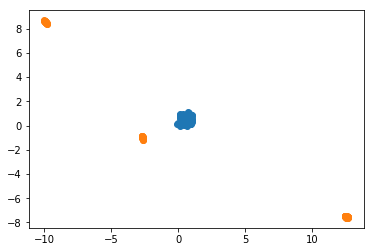

Loss: 0.00078


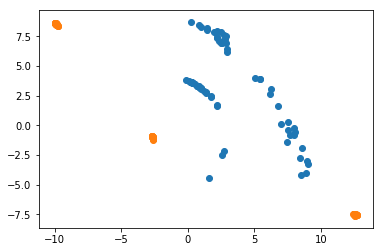

Loss: 0.00059


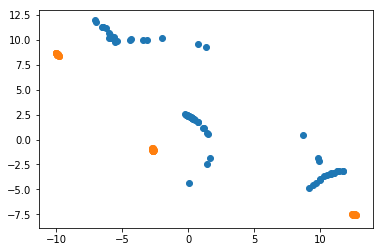

Loss: 0.00048


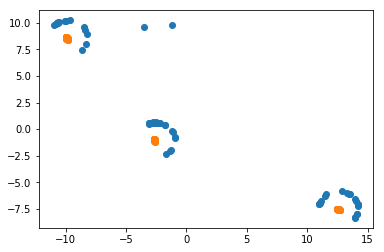

Loss: 0.00045


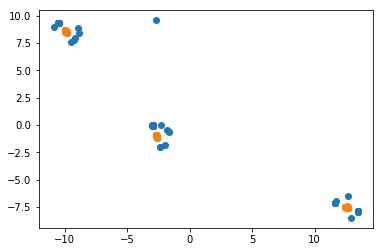

Loss: 0.00045


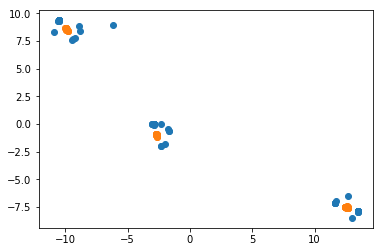

Loss: 0.00044


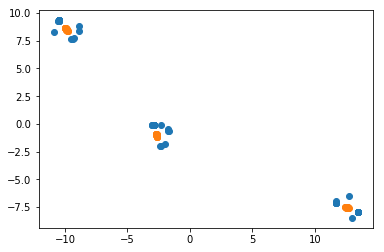

Loss: 0.00044


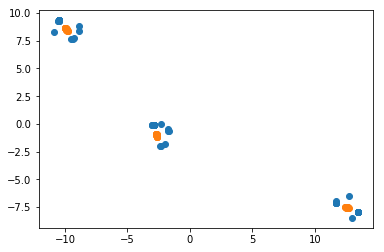

Loss: 0.00044


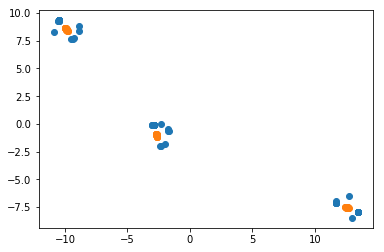

Loss: 0.00044


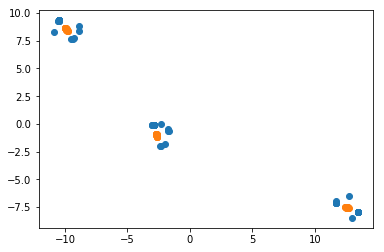

In [41]:
Yp, P, Q = tsne_embed(X=X, Xp=Xp, Y=Y, perplexity=15.0)

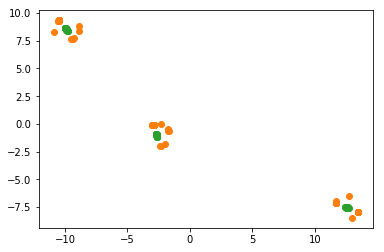

In [28]:
plt.scatter(Yp[:,0].numpy(), Yp[:,1].numpy())
plt.scatter(Xp[:,0].numpy(), Xp[:,1].numpy())
plt.show()

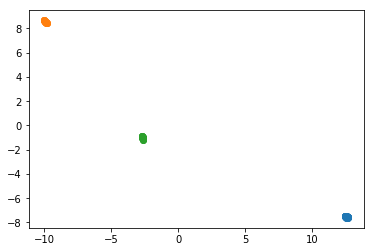

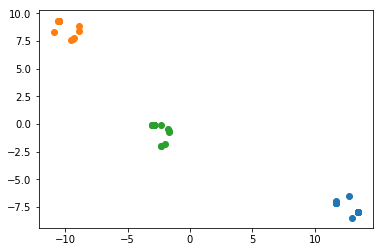

In [42]:
plt.scatter(Xp[0:20,0], Xp[0:20,1])
plt.scatter(Xp[20:40,0], Xp[20:40,1])
plt.scatter(Xp[40:60,0], Xp[40:60,1])
plt.show()
plt.scatter(Yp[0:20,0], Yp[0:20,1])
plt.scatter(Yp[20:40,0], Yp[20:40,1])
plt.scatter(Yp[40:70,0], Yp[40:70,1])
plt.show()